# Gesture Recognition


In [0]:
import numpy as np
import os
import cv2
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(30)
rn.seed(30)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(30)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import os
print(os.listdir("../content/gdrive/My Drive/Colab Notebooks/Project_data"))

['val', 'train', 'val.csv', 'train.csv']


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [0]:
train_doc = np.random.permutation(open('../content/gdrive/My Drive/Colab Notebooks/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../content/gdrive/My Drive/Colab Notebooks/Project_data/val.csv').readlines())
train_batch_size = 16
valid_batch_size = 16

In [0]:
# specify image size and channels
img_channels = 3
img_rows = 80
img_cols = 80
img_frms = 15

# number of classes
nb_classes = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
def load_batch_data(source_path, folder_list, batch_size, t, batch):
    img_idx = [x for x in range(0,30) if x%2 ==1]#create a list of image numbers you want to use for a particular video
    batch_data = np.zeros((batch_size,len(img_idx),img_rows,img_cols,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
            image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape[0] != image.shape[1]:
                image = image[0:120,20:140]
            image = cv2.resize(image,(img_rows,img_cols))

            batch_data[folder,idx,:,:,0] = image[:,:,0]/image[:,:,0].max()#normalise and feed in the image
            batch_data[folder,idx,:,:,1] = image[:,:,0]/image[:,:,1].max()#normalise and feed in the image
            batch_data[folder,idx,:,:,2] = image[:,:,0]/image[:,:,2].max()#normalise and feed in the image

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
    

In [0]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            yield load_batch_data(source_path, folder_list, batch_size, t, batch) #you yield the batch_data and the batch_labels, remember what does yield do

        
        # code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_data(source_path, folder_list, batch_size, t, batch)


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '../content/gdrive/My Drive/Colab Notebooks/Project_data/train'
val_path = '../content/gdrive/My Drive/Colab Notebooks/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


## Model


In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


from keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed


base_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_rows,img_cols,img_channels))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(img_frms,img_rows,img_cols,img_channels)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [33]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_35 (TimeDis (None, 15, 64)            14845824  
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 32)            9312      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2352      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
Total params: 14,857,669
Trainable params: 142,981
Non-trainable params: 14,714,688
____________________________________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [0]:
train_generator = generator(train_path, train_doc, train_batch_size)
val_generator = generator(val_path, val_doc, valid_batch_size)

In [0]:
model_name = '../content/gdrive/My Drive/Colab Notebooks/'+'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [0]:

if (num_train_sequences%train_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/train_batch_size)
else:
    steps_per_epoch = (num_train_sequences//train_batch_size) + 1

if (num_val_sequences%valid_batch_size) == 0:
    validation_steps = int(num_val_sequences/valid_batch_size)
else:
    validation_steps = (num_val_sequences//valid_batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [41]:
hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
42/42 [==============================] - 69s 2s/step - loss: 1.5471 - categorical_accuracy: 0.2881 - val_loss: 1.4694 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00001-1.55001-0.28808-1.46937-0.27000.h5
Epoch 2/50
42/42 [==============================] - 26s 620ms/step - loss: 1.4879 - categorical_accuracy: 0.3469 - val_loss: 1.3470 - val_categorical_accuracy: 0.4643

Epoch 00002: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00002-1.48795-0.34694-1.34705-0.46429.h5
Epoch 3/50
42/42 [==============================] - 30s 712ms/step - loss: 1.4350 - categorical_accuracy: 0.3878 - val_loss: 1.3095 - val_categorical_accuracy: 0.5714


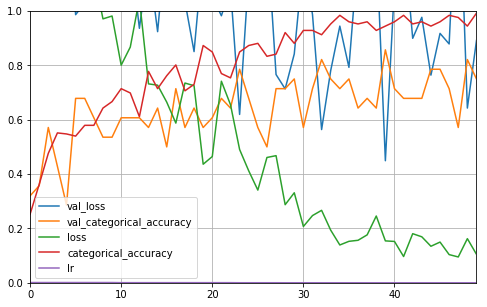

In [18]:
import pandas as pd
pd.DataFrame(hist.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [0]:
#Model 2 Customised LSTM

input_shape=(img_frms,img_rows,img_cols,img_channels)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),
    activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3),
    kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False, dropout=0.5))

model.add(Dense(nb_classes, activation='softmax'))

In [24]:
optimiser = optimizers.Adam()#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 15, 80, 80, 16)    448       
_________________________________________________________________
time_distributed_16 (TimeDis (None, 15, 78, 78, 16)    2320      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 39, 39, 16)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 39, 39, 32)    4640      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 39, 39, 32)    9248      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 19, 19, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 19, 19, 64)   

In [0]:
train_generator = generator(train_path, train_doc, train_batch_size)
val_generator = generator(val_path, val_doc, valid_batch_size)

In [26]:
hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size =Source path =   16../content/gdrive/My Drive/Colab Notebooks/Project_data/train
 ; batch size = 16
42/42 [==============================] - 67s 2s/step - loss: 1.5671 - categorical_accuracy: 0.2810 - val_loss: 1.3769 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00001-1.57185-0.27903-1.37691-0.45000.h5
Epoch 2/50
42/42 [==============================] - 25s 590ms/step - loss: 1.4094 - categorical_accuracy: 0.4592 - val_loss: 1.2634 - val_categorical_accuracy: 0.5357

Epoch 00002: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00002-1.40942-0.45918-1.26345-0.53571.h5
Epoch 3/50
42/42 [==============================] - 28s 673ms/step - loss: 1.4152 - categorical_accuracy: 0.4388 - val_loss: 1.3340 - val_categorical_accuracy: 0.4643


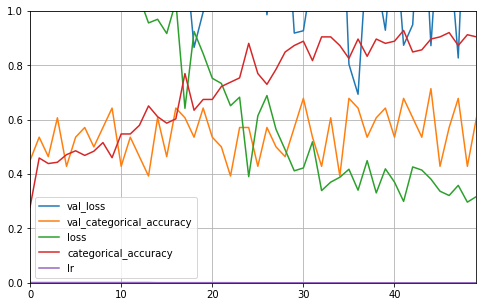

In [27]:
import pandas as pd
pd.DataFrame(hist.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [0]:
#model 3 Customized CNN and GRU

input_shape=(img_frms,img_rows,img_cols,img_channels)

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3),
    activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(16, (3,3),
    kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.5))
model.add(GRU(128, return_sequences=False, dropout=0.5))

model.add(Dense(nb_classes, activation='softmax'))

In [29]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_25 (TimeDis (None, 15, 80, 80, 16)    448       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 78, 78, 16)    2320      
_________________________________________________________________
time_distributed_27 (TimeDis (None, 15, 39, 39, 16)    0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 15, 39, 39, 32)    4640      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 15, 39, 39, 32)    9248      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 15, 19, 19, 32)    0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 15, 19, 19, 64)   

In [0]:
train_generator = generator(train_path, train_doc, train_batch_size)
val_generator = generator(val_path, val_doc, valid_batch_size)

In [31]:
hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/val ; batch size = 16
Source path =  ../content/gdrive/My Drive/Colab Notebooks/Project_data/train ; batch size = 16
42/42 [==============================] - 68s 2s/step - loss: 1.6121 - categorical_accuracy: 0.1775 - val_loss: 1.6038 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00001-1.61189-0.17798-1.60382-0.23000.h5
Epoch 2/50
42/42 [==============================] - 26s 607ms/step - loss: 1.6026 - categorical_accuracy: 0.2211 - val_loss: 1.5944 - val_categorical_accuracy: 0.2143

Epoch 00002: saving model to ../content/gdrive/My Drive/Colab Notebooks/model_init_2019-10-0718_14_20.477640/model-00002-1.60258-0.22109-1.59439-0.21429.h5
Epoch 3/50
42/42 [==============================] - 28s 661ms/step - loss: 1.6073 - categorical_accuracy: 0.2041 - val_loss: 1.6072 - val_categorical_accuracy: 0.1071
